# Кластеризация пользователей интернет-магазина

## Получение и изучение данных

### Поставленная задача и исходные данные

**Заказчик: сервис по автоматизации контекстной рекламы "Объявка.ру"**

**Цель**

- Разделить пользователей сервиса на три сегмента:
    - базовый,
    - продвинутый
    - премиальный.
- Для каждой категории составить портрет среднестатистического пользователя.

---

Для достижения цели необходимо научиться определять, насколько похожи пользователи, и разбить их на группы.
Признаки, определяющие похожесть пользователей сервиса:
- `timespent` — среднее время сессии (это показатель активности пользователя)
- `months` — количество месяцев с первой покупки/с момента регистрации на сервисе (этот признак описывает лояльность пользователя)
- `purchase` — максимальный чек (определяет значимость уровень пользователя - чем больше, тем выше уровень, ближе к премиальному)

Признаки типичного пользователя, составленные отделом маркетинга, в каждом сегменте:
- Базовый: `timespent` — 50 минут, `purchase` — 20 тысяч рублей, `months` — 5 месяцев.
- Продвинутый: `timespent` — 20 минут, `purchase` — 30 тысяч рублей, `months` — 10 месяцев.
- Премиальный: `timespent` — 20 минут, `purchase` — 80 тысяч рублей, `months` — 8 месяцев.

Признаки нужны, чтобы подсказать алгоритму, где искать кластеры.

Значения этих признаков передадим на вход k-средних, чтобы задать начальные центроиды — это опциональный параметр.

В задачах сравним обученную без этого параметра модель и модель с начальными центроидами.

### Импорт библиотек и базовые настройки

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '13'

import seaborn as sns
sns.set_style('darkgrid')
sns.set_palette('Set2')

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 

### Чтение данных

In [2]:
data = pd.read_csv('https://code.s3.yandex.net/datasets/segments.csv')
data_c = data.copy()
data_k = data.copy()

In [3]:
data.head()

,timespent,purchase,months
0,9.749627,26.984142,14.0
1,30.416766,5.916530,15.0
2,8.809746,35.502827,14.0
3,31.418008,9.820529,18.0
4,48.279014,18.359423,2.0


## Алгоритм k-средних, целевая функция

Передадим значения признаков на вход k-средних.

В задачах сравним обученную с начальными центроидами модель и без.

In [4]:
centers = np.array([[20, 80, 8], [50, 20, 5], [20, 30, 10]]) # сохранение значений начальных центроидов в переменной

model = KMeans(n_clusters=3, random_state=12345)             # обучение модели для трёх кластеров пользователей
model.fit(data)

print("Центроиды кластеров:")
print(model.cluster_centers_)                                 
print("Целевая функция:")
print(model.inertia_)

model_c = KMeans(n_clusters=3, init=centers, random_state=12345) # обучение модели для трёх кластеров с нач. центроидами
model_c.fit(data)

print("Центроиды кластеров для модели с начальными центроидами:")
print(model_c.cluster_centers_)
print("Целевая функция модели с начальными центроидами:")
print(model_c.inertia_)

Центроиды кластеров:
[[40.14472236 15.00741697  8.56      ]
 [10.90357994 29.90244865 15.096     ]
 [10.68632155 98.90275017 10.856     ]]
Целевая функция:
68431.5099940037
Центроиды кластеров для модели с начальными центроидами:
[[10.68632155 98.90275017 10.856     ]
 [50.06201472 19.62701512  1.808     ]
 [20.56550497 20.14513373 15.204     ]]
Целевая функция модели с начальными центроидами:
74253.20363562094


- С начальными центроидами кол-во запусков алгоритма `n_init ` = 1, без начальных центроидов `n_init ` = 10 (значение по умолчанию)
- При каждом запуске алгоритма целевая функция получается минимальной для конкретного стартового набора объектов кластера - локальный минимум.
- Целевая функция потерь с начальными центроидами получилась больше, потому что алгоритм запускался всего один раз. При 10-кратном запуске случайно удалось найти начальные центроиды лучше.
- Чем больше параметр n_init, тем меньше целевая функция. Запуская алгоритм несколько раз, можно выбрать такой вариант деления объектов на кластеры, где целевая функция будет минимальна.

## Визуализация

- Изучим влияние параметра `max_iter`, определяющего количество итераций алгоритма. Чем их больше, тем ближе к локальному минимуму мы подойдём.
- Максимальное число итераций по умолчанию равно 300.
- Чем больше параметр max_iter, тем меньше целевая функция. С каждой итерацией значение целевой функции становится меньше или стабилизируется.

Для визуализации данных о пользователях сервиса построим график методом `pairplot` из библиотеки seaborn.

- На диагонали находится распределение признака: `purchase`, `timespent` и `months`.
- В других ячейках — диаграммы рассеяния между всеми парами признаков.
- Тип графика по диагонали определяется параметром `diag_kind`.

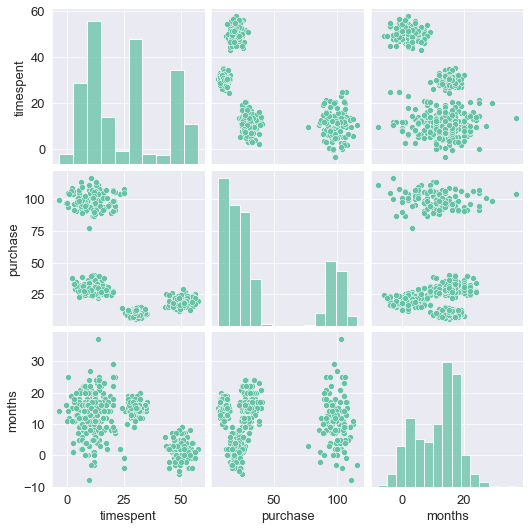

In [5]:
sns.pairplot(data, diag_kind='hist');

На графике изображены скопления точек — это будущие кластеры.

Наблюдения:
- Чётко выделяются четыре группы объектов на проекции пары признаков: `purchase` (средний чек) и `timespent` (среднее время сессии).
- На других проекциях видно по две-три группы точек.
- Скопление объектов с высокими значениями `purchase` заметно отделено от остальных точек.

Добавим заливку кластеров в график модели, обученной без начальных центроидов. Правила заливки задаёт параметр `hue`. Он принимает на вход массив из строковых переменных. Поэтому в массив строк переведём номера кластеров. А чтобы добавить на график центроиды, дадим им названия. Затем все данные объединим.

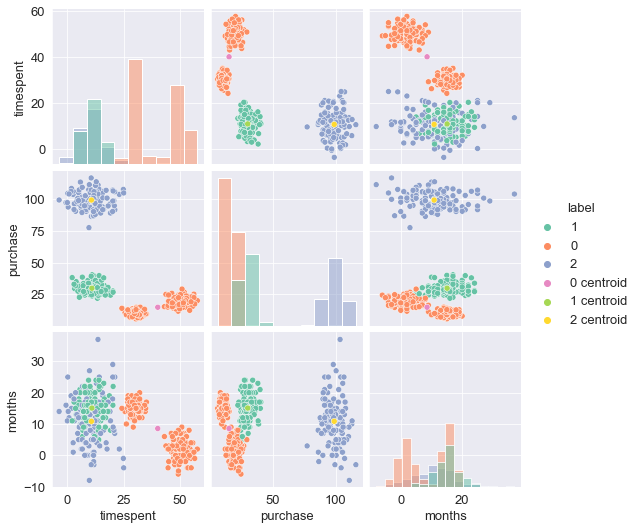

In [6]:
centroids = pd.DataFrame(model.cluster_centers_, columns=data.columns)
# Добавление столбца с номером кластера
data['label'] = model.labels_.astype(str)
centroids['label'] = ['0 centroid', '1 centroid', '2 centroid']
# Сброс индекса понадобится дальше
data_all = pd.concat([data, centroids], ignore_index=True)

# Построение графика (сохраним соответствующий графику объект — `pairgrid`)
pairgrid = sns.pairplot(data_all, hue='label', diag_kind='hist'); 

Наши наблюдения подтвердились: группа точек с высокими значениями признака `purchase` попала в отдельный кластер. Мы определили премиальный сегмент.

Чтобы определить подходящие базовому и продвинутому сегментам кластеры, на график добавим начальные центроиды дополнительным слоем.

Дополнительные значения для построения графика передадим через атрибут data:

In [7]:
centroids_init = pd.DataFrame([[20, 80, 8], [50, 20, 5], [20, 30, 10]], \
                             columns=data.drop(columns=['label']).columns)
centroids_init['label'] = 4

In [8]:
centroids_init

,timespent,purchase,months,label
0,20,80,8,4
1,50,20,5,4
2,20,30,10,4


В каждой строке столбца `label` мы указали значение 4. Функция этого столбца формальна: метод `map_offdiag` библиотеки `seaborn` требует, чтобы в дополнительных данных присутствовал столбец, который передаётся параметру `hue`. Если не создать такой столбец, произойдёт ошибка. Добавить в дополнительный столбец `label` необходимо такое значение, которое в основном столбце `label` не встречалось, например, 4.

Вызовем метод `map_offdiag`, он строит данные из `pairgrid.data` на проекциях вне диагоналей. Параметр `func` определяет тип графика, `s` — размер (от англ. size), `marker` — форму точек, а `palette` — цветовую палитру:

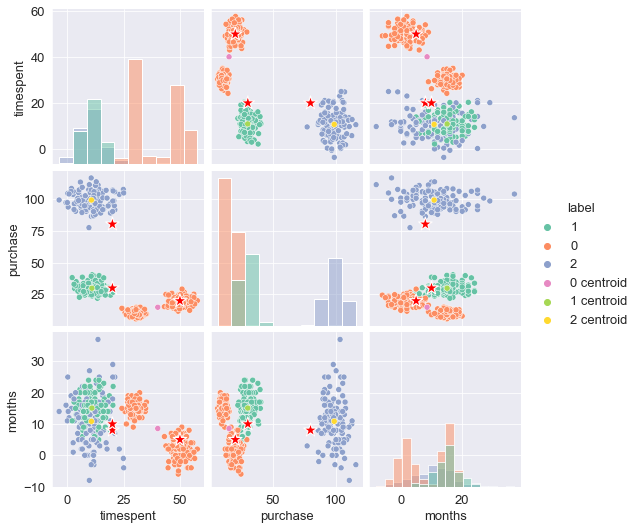

In [9]:
pairgrid = sns.pairplot(data_all, hue='label', diag_kind='hist')
pairgrid.data = centroids_init 
pairgrid.map_offdiag(func=sns.scatterplot, s=200, marker='*', palette='flag');

Посмотрим на проекцию `purchase` и `timespent`. У кластера с номером «1» среднее время сессии меньше — значит, это продвинутый сегмент, а кластер с номером «0» — базовый.

Найдём различия между полученным графиком и результатом кластеризации с начальными центроидами.

- Обучим модель с начальными центроидами `centers`.
- Построим диаграмму `pairplot` с заливкой по кластерам и центроидами полученных кластеров.
- Начальные центроиды добавим отдельным слоем без заливки.

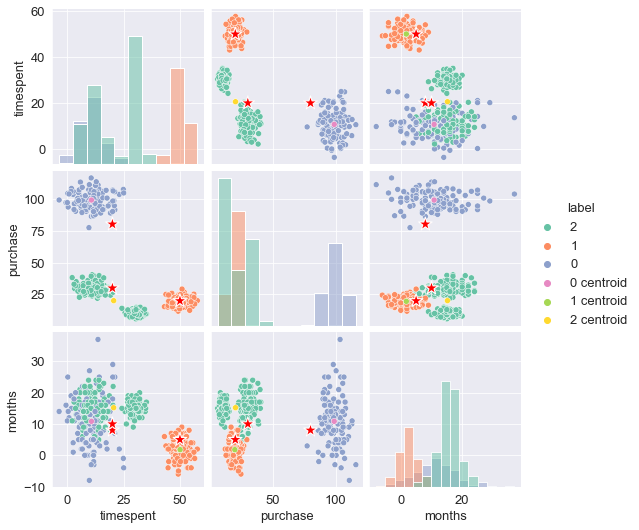

In [10]:
centroids_c = pd.DataFrame(model_c.cluster_centers_, columns=data_c.columns)
data_c['label'] = model_c.labels_.astype(str)
centroids_c['label'] = ['0 centroid', '1 centroid', '2 centroid']
data_all_c = pd.concat([data_c, centroids_c], ignore_index=True)

pairgrid_c = sns.pairplot(data_all_c, hue='label', diag_kind='hist')
# Дополнительный слой для центроидов
# Сформируем таблицу для дополнительного слоя
centroids_init_c = pd.DataFrame([[20, 80, 8], [50, 20, 5], [20, 30, 10]], \
                             columns=data_c.drop(columns=['label']).columns)
# Сформируем "заглушку"
centroids_init_c['label'] = 4
pairgrid_c.data = centroids_init_c 
pairgrid_c.map_offdiag(func=sns.scatterplot, s=200, marker='*', palette='flag');

- Продвинутый сегмент стал базовым. Особенно это заметно на проекции пары `purchase` и `timespent`.
- Теперь разница в значении целевой функции объяснима: алгоритм без начальных центроидов определил кластеры, внутрикластерное расстояние для которых минимально. А начальные центроиды эти кластеры сдвинули.

Выделим четыре сегмента вместо трёх по согласованию с отделом маркетинга.

## Оптимальное количество кластеров

Оптимальное количество кластеров определим при помощи метода локтя. Чтобы построить график метода, нужно составить список из значений целевой функции для разного количества кластеров: от 1 до 10 (реже 20). Для этого обучим модель несколько раз и сохраним значения целевой функции каждой модели в список `distortion`:

In [11]:
distortion = []
K = range(1, 8)
for k in K:
    model_k = KMeans(n_clusters=k, random_state=12345)
    model_k.fit(data_k)
    distortion.append(model_k.inertia_) 

Отобразим полученный список на графике:

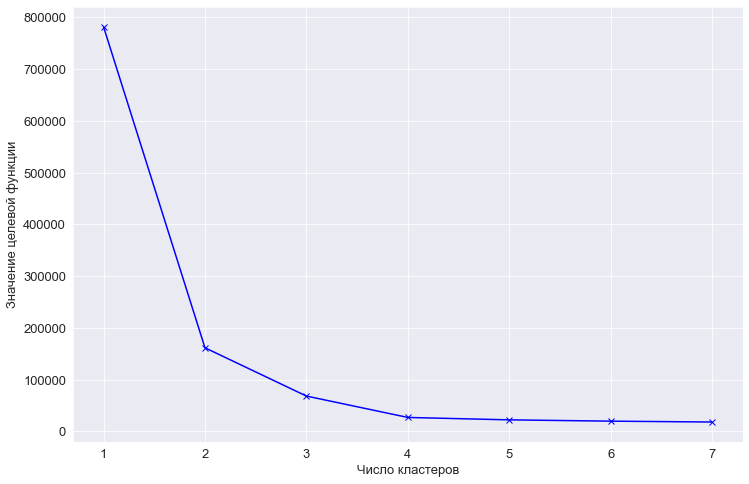

In [12]:
plt.figure(figsize=(12, 8))
plt.plot(K, distortion, 'bx-')
plt.xlabel('Число кластеров')
plt.ylabel('Значение целевой функции')
plt.show() 

Значение целевой функции сначала резко уменьшается, а затем выходит на плато, момент перехода отражает оптимальное количество кластеров.

На этом графике плато начинается после четвёртого кластера. Причём неплохие результаты также показывают второй и третий кластеры: после них скачок вниз целевой функции не очень большой.

Посчитаем значения целевой функции для моделей, обученных на разном количестве кластеров.

In [13]:
data_k

,timespent,purchase,months
0,9.749627,26.984142,14.0
1,30.416766,5.916530,15.0
2,8.809746,35.502827,14.0
3,31.418008,9.820529,18.0
4,48.279014,18.359423,2.0
...,...,...,...
495,30.498767,13.154907,15.0
496,7.192033,27.348396,9.0
497,20.174739,98.147402,29.0
498,56.226202,22.613374,1.0


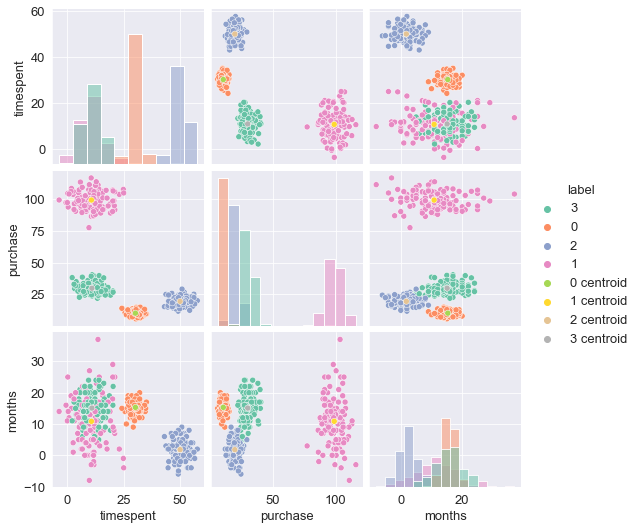

In [14]:
# Обучение модели для 4-х кластеров
data_4 = data_k.copy()
model_4 = KMeans(n_clusters=4, random_state=12345)
model_4.fit(data_4)

centroids_4 = pd.DataFrame(model_4.cluster_centers_, columns=data_4.columns)
data_4['label'] = model_4.labels_.astype(str)
centroids_4['label'] = ['0 centroid', '1 centroid', '2 centroid', '3 centroid']
data_all_4 = pd.concat([data_4, centroids_4], ignore_index=True)

# Построение графика
sns.pairplot(data_all_4, hue='label', diag_kind='hist');

- Все группы данных попали в кластеры.

Далее найдём типичного пользователя каждого сегмента.

Обучим также модель для трёх кластеров и сравним типичных позьзователей для 3-х и 4-х кластеров

In [15]:
# Обучение модели для 3-х кластеров
data_3 = data_k.copy()
model_3 = KMeans(n_clusters=3, random_state=12345)
model_3.fit(data_3)

print("Типичные пользователи сегментов для 3-х кластеров:")
print(model_3.cluster_centers_.round())

print("Типичные пользователи сегментов для 4-х кластеров:")
print(model_4.cluster_centers_.round())

Типичные пользователи сегментов для 3-х кластеров:
[[40. 15.  9.]
 [11. 30. 15.]
 [11. 99. 11.]]
Типичные пользователи сегментов для 4-х кластеров:
[[30. 10. 15.]
 [11. 99. 11.]
 [50. 20.  2.]
 [11. 30. 15.]]


- Два кластера остались прежними, а третий разделился на два, причём значение среднего чека в новом кластере самое маленькое.

## Интерпретация результата

Вернёмся к признакам типичных пользователей каждого сегмента:

- Базовый: среднее время сессии — 50 минут, средний чек — 20 тысяч рублей, 5 месяцев с момента регистрации на сервисе.
- Продвинутый: среднее время сессии — 20 минут, средний чек — 30 тысяч рублей, 10 месяцев с момента регистрации.
- Премиальный: среднее время сессии — 20 минут, средний чек — 80 тысяч рублей, 8 месяцев с момента регистрации.

В четырёх кластерах базовый сегмент с характеристиками [40. 15. 9.] разбился на две подгруппы: [50. 20. 2.] и [30. 10. 15.].

«Три кластера» пришло от топ-менеджмента, и от этого числа может многое зависеть. Дополнительный сегмент можно ввести в будущем по следующим причинам:
- Время с момента регистрации пользователей для двух подгрупп разное (2 и 15 месяцев), причём средний чек больше у новичков, есть смысл ввести тариф для начинающих.
- Четыре кластера видны на части проекций. В обученных на четырёх кластерах моделях центроиды находятся ровно в своих сегментах, на трёх — один центр лежит между кластерами, он плохо описывает сегмент: пользователей с близкими значениями нет. В четырёх кластерах пользователи описаны хорошо.
- Среднее время сессии для двух подгрупп базового сегмента разное, оно больше у недавно зарегистрировавшихся на сервисе, т.к. новички знакомятся с возможностями сервиса. Для них сто́ит ввести дополнительный сегмент.